In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')

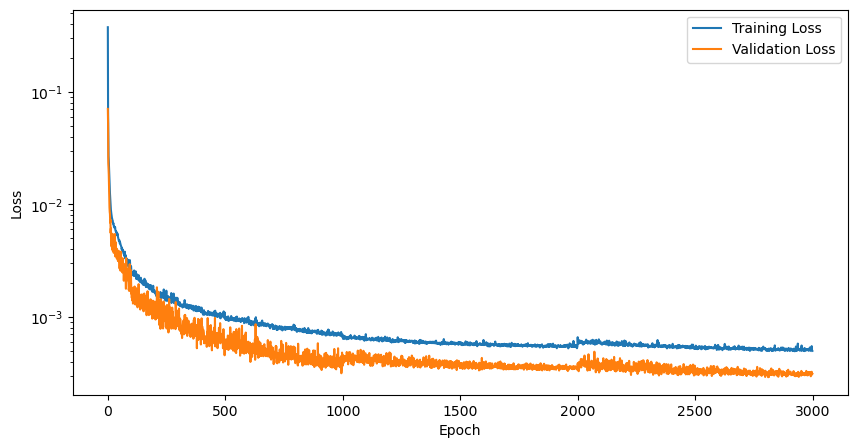

In [4]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [5]:
from train import *
import torch
train_dataset, test_dataset, n_features, n_inputs = data_preparation()
params = Params(n_features, n_inputs)
model = build_model(params)
model = torch.load('model.pth')

['/home/shiqi/code/model_combination_Argos/gan_transformer', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']
File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [6]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [7]:
for batch in train_loader:
    x_train, y_train, u1_train, u2_train = batch

In [8]:
y_pred_scaled = model(x_train, u1_train, u2_train).detach().numpy().squeeze()
y_pred = scaler_x.inverse_transform(y_pred_scaled)

In [9]:
y_true = scaler_x.inverse_transform(y_train.detach().numpy().squeeze())

In [10]:
err = y_pred - y_true
err_norm = np.linalg.norm(err)
y_true_norm = np.linalg.norm(y_true)
ratio = err_norm / y_true_norm
print(ratio)


0.013337382


In [11]:
## Long term predict
## Test data preparation
y_dataset = []
u1_dataset = []
u2_dataset = []


for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
        
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u1_data, u2_data = load_dataset(data_dict)
        y_dataset.append(y_data)
        u1_dataset.append(u1_data)
        u2_dataset.append(u2_data)
    else:
        print(f"File not found: {data_file_path}")


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [12]:
# start from the non-zero point
y_data_pred_50traj = []
for y_data, u1_data, u2_data in zip(y_dataset, u1_dataset, u2_dataset):
    steps = 150
    n_target = y_data.shape[1]
    y_data_scaled = scaler_x.transform(y_data)
    u1_data_scaled = scaler_u.transform(u1_data)
    u2_data_scaled = scaler_u.transform(u2_data)
    y_data_pred_scaled = [torch.tensor(y_data_scaled[0:1,:], dtype = torch.float32)]
    for step in range(steps - 1):
        x = torch.tensor(y_data_pred_scaled[-1].reshape((1, 1, -1)),dtype = torch.float32)
        u1 = torch.tensor(u1_data_scaled[step+1:step+2, :].reshape((1, 1, -1)), dtype = torch.float32)
        u2 = torch.tensor(u1_data_scaled[step+1:step+2, :].reshape((1, 1, -1)), dtype = torch.float32)
        y_pred = model(x, u1, u2)
        y_data_pred_scaled.append(y_pred.reshape(1, -1))
    y_data_pred_scaled = torch.cat(y_data_pred_scaled, dim = 0).detach().numpy()
    # print(np.shape(y_data_pred_scaled))
    y_data_pred = scaler_x.inverse_transform(y_data_pred_scaled)
    y_data_pred_50traj.append(y_data_pred)

In [15]:
errors = [y_data_pred_50traj[i] - y_dataset[i][:steps, :] for i in range(len(y_data_pred_50traj))]

error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

data_norms = [np.linalg.norm(y_dataset[i][:steps, :]) for i in range(len(y_dataset))]

relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))] 

In [16]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

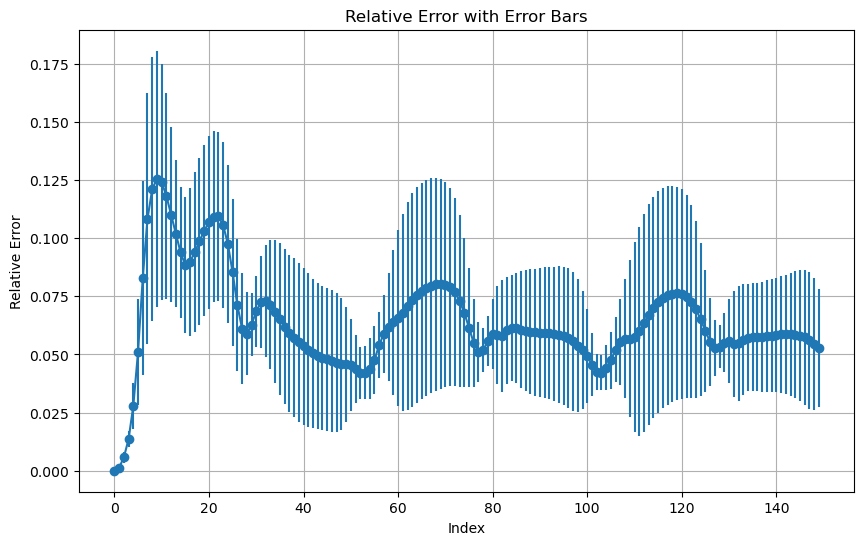

In [17]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [19]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(y_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [20]:
np.mean(domain_relative_error)

0.8872948150586578

In [21]:
y_dataset[0].shape

(150, 6957)

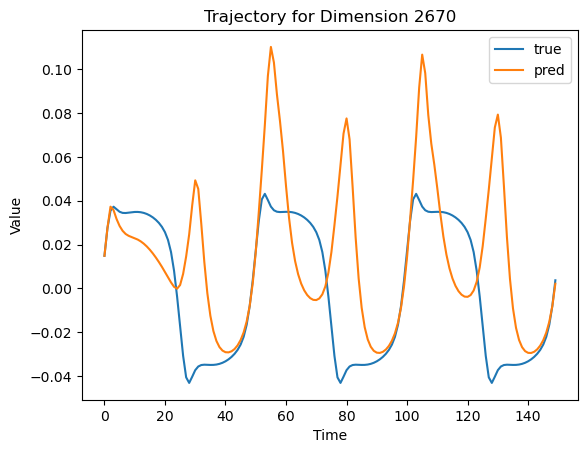

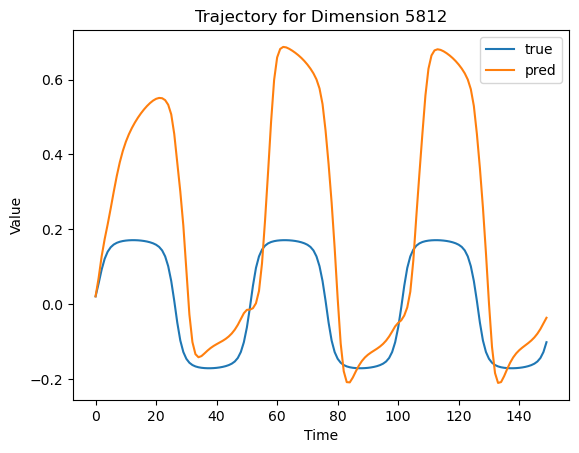

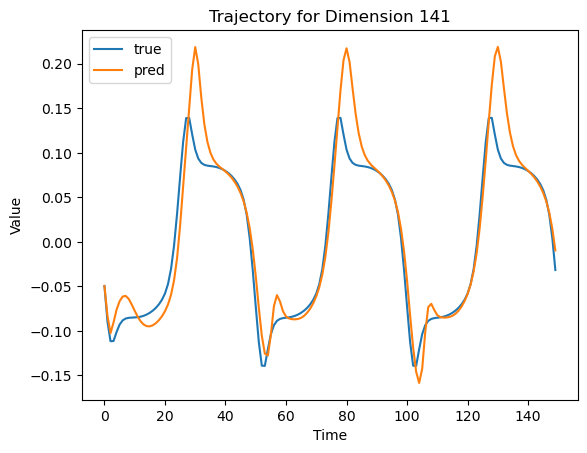

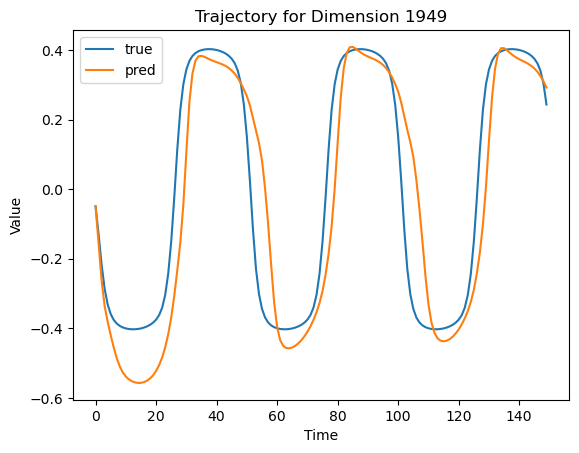

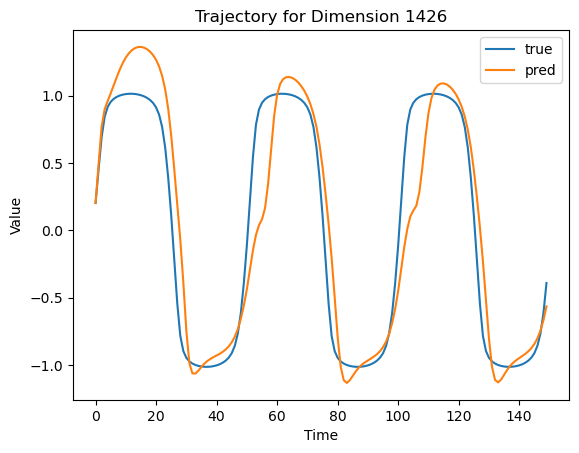

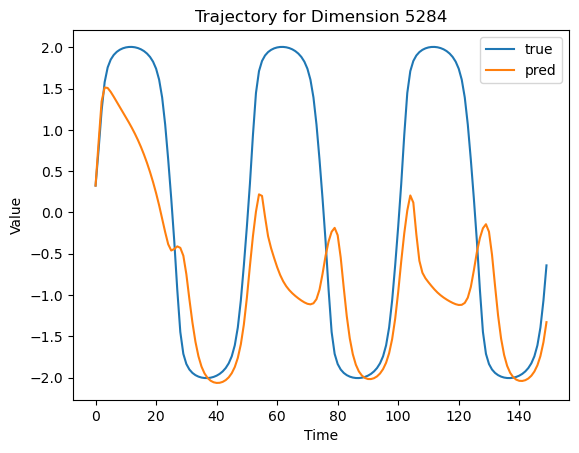

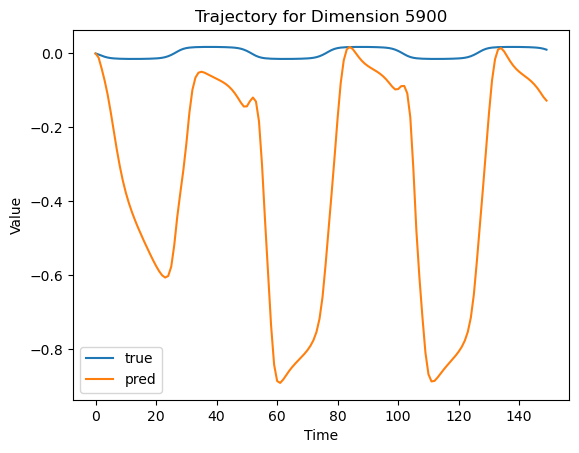

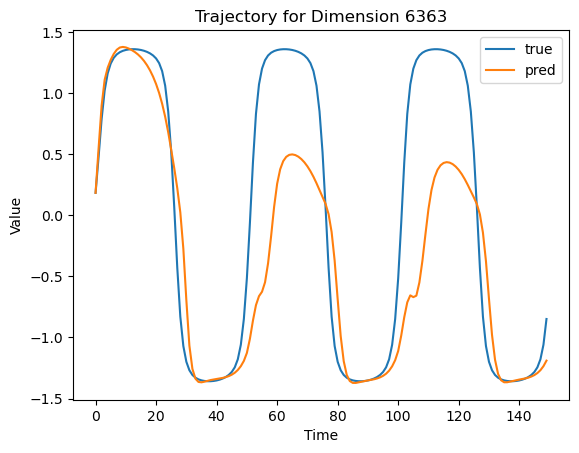

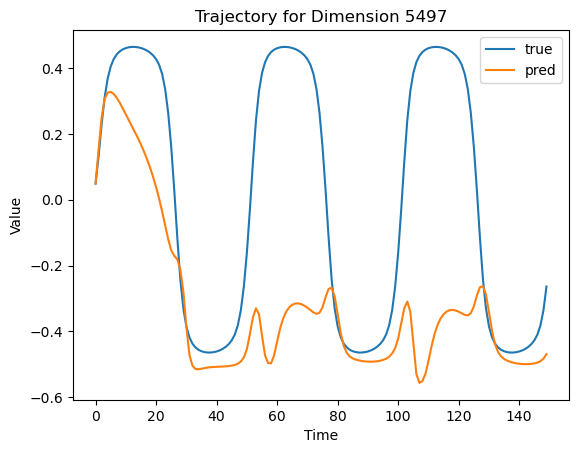

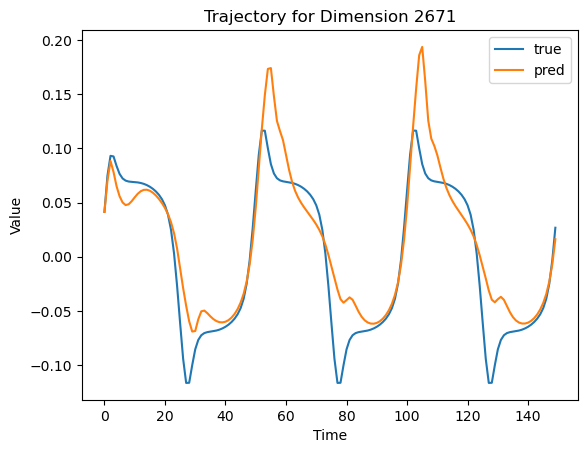

In [24]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = y_dataset[0].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)

for i in selected_dimensions:
    plt.figure()
    y_true = y_dataset[0]
    y_pred = y_data_pred_50traj[0]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()